In [1]:
import os

In [6]:
base_path = "C:/Users/user/Downloads/train_images"
for count, file in enumerate(sorted(os.listdir(base_path))):
    os.rename(f"{base_path}/{file}", f"{base_path}/{count}.jpg")

# Parse scaning images

In [55]:
data_base_path = "C:/Users/user/OneDrive - 성균관대학교/Desktop/HealthPort/illumination"
orig_folder = "camera"
scan_folder = "scan"

In [56]:
all_camera_files = os.listdir(f"{data_base_path}/{orig_folder}")
all_scan_files = os.listdir(f"{data_base_path}/{scan_folder}")

In [57]:
all_camera_names = [file.split('.')[0] for file in all_camera_files]
all_scan_names = [file.split('.')[0] for file in all_scan_files]

In [58]:
print(len(all_camera_names))
print(len(all_scan_names))

1001
290


In [59]:
no_cam_names = []
for file in os.listdir(f"{data_base_path}/{scan_folder}"):
    name = file.split('.')[0].split('_')[0]
    if name not in all_camera_names:
        no_cam_names.append(name)
        

no_scan_names = []
for file in os.listdir(f"{data_base_path}/{orig_folder}"):
    name = file.split('.')[0].split('_')[0]
    if name not in all_scan_names:
        if name not in no_scan_names:
            no_scan_names.append(name)

In [60]:
print(len(no_cam_names))
print(len(no_scan_names))

78
347


In [61]:
no_cam_names

['강복은',
 '강순임',
 '강옥회',
 '강윤남',
 '곽경훈',
 '곽경훈',
 '권창순',
 '길청남',
 '김경석',
 '김경화',
 '김상남',
 '김성석',
 '김연엽',
 '김우신',
 '김유속',
 '김이경',
 '김잉석',
 '김진영',
 '김현미',
 '김후자',
 '노미숙',
 '노중운',
 '민병',
 '박경연',
 '박경희',
 '박명순',
 '박수봉',
 '박순임',
 '박영곤',
 '박영숙',
 '박인말',
 '박혜인',
 '방인숙',
 '방정자',
 '백이',
 '손분순',
 '손우정',
 '송학래',
 '신학룡',
 '안병옥',
 '유기문',
 '유태순',
 '윤동웅',
 '이경미',
 '이복회',
 '이봉하',
 '이상수',
 '이속희',
 '이순교',
 '이은육',
 '이점순',
 '이정민',
 '이한희',
 '이호영',
 '임대섭',
 '임언수',
 '임종복',
 '임춘득',
 '장란순',
 '장평임',
 '전봉선',
 '정멍희',
 '정병님',
 '정상량',
 '정정옥',
 '정태석',
 '조상순',
 '조인숙',
 '조향순',
 '최들자',
 '최묵형',
 '최순임',
 '추예섭',
 '추옥련',
 '탁현철',
 '하추자',
 '한종대',
 '허광호']

In [62]:
no_scan_names

['강경용',
 '강남순',
 '강분남',
 '강삼례',
 '강순연',
 '강옥희',
 '강우신',
 '강우준',
 '강윤상',
 '강윤수',
 '강윤순',
 '강진석',
 '강추자',
 '강평임a',
 '강평임b',
 '강혜숙',
 '강후자',
 '고남순',
 '고동오b',
 '고등오b',
 '고재원a',
 '곽기봉',
 '곽청일',
 '국중민',
 '권기봄',
 '권영규',
 '권영자',
 '권오명',
 '권오윤',
 '길창남',
 '김개남',
 '김계둔',
 '김광수',
 '김균희',
 '김기주',
 '김독치',
 '김동균',
 '김두선',
 '김말숙',
 '김목자',
 '김문걸',
 '김문결',
 '김미대자',
 '김미수',
 '김미숙a',
 '김미은',
 '김병준',
 '김삼순',
 '김상문',
 '김석재',
 '김선자',
 '김선전',
 '김성헌',
 '김수용',
 '김순자a',
 '김순자c',
 '김승만',
 '김연자b',
 '김연조',
 '김영락',
 '김영자',
 '김영준',
 '김영희',
 '김옥선',
 '김옥자a',
 '김옥자b',
 '김용민',
 '김용수',
 '김용일',
 '김윤지',
 '김일섭',
 '김임석',
 '김재규',
 '김재성',
 '김적남a',
 '김적남b',
 '김정례',
 '김정애',
 '김정희',
 '김종년',
 '김종식a',
 '김종헌',
 '김종훈',
 '김주연',
 '김천자',
 '김청기',
 '김청자',
 '김태선',
 '김태순',
 '김헌봉',
 '김현숙',
 '김효선',
 '깅동열',
 '나금례',
 '나태순',
 '남옥련',
 '노동준',
 '노정순',
 '노종운',
 '노종준',
 '류도형',
 '맹한미',
 '문순덕',
 '문양자',
 '문필남',
 '박경녀',
 '박경배',
 '박경선',
 '박경주',
 '박금옥',
 '박덕이',
 '박동욱',
 '박명근',
 '박명숙',
 '박복녀',
 '박분순',
 '박분자',
 '박산옥',
 '박선율',
 '박성자',
 '박성훈',
 '박숙재',
 '박숙진',
 

# Create new folder for final files

In [9]:
from PIL import Image, ImageOps
import numpy as np
import copy

final_orig_folder = "final_camera"
final_scan_folder = "final_scan"


In [ ]:
for file in os.listdir(f"{data_base_path}/{scan_folder}"):
    name = file.split('.')[0]#.split('_')[0]
    
    if name in all_camera_names:
        #no_cam_names.append(name)
        base_name = copy.deepcopy(name)
        count = 2
        while name in all_camera_names:
            orig = Image.open(f"{data_base_path}/{scan_folder}/{file}")
            orig.save(f"{data_base_path}/{final_scan_folder}/{name}.jpg")
            
            name = f"{base_name}_{count}"
            count+=1
            
        
        #break

In [11]:
from pillow_heif import register_heif_opener

register_heif_opener()


In [14]:
for file in os.listdir(f"{data_base_path}/{orig_folder}"):
    name = file.split('.')[0].split('_')[0]
    save_name = file.split('.')[0]#.split('_')[0]
    
    if name in all_scan_names:
        orig = Image.open(f"{data_base_path}/{orig_folder}/{file}")
        orig = ImageOps.exif_transpose(orig)

        orig.save(f"{data_base_path}/{final_orig_folder}/{save_name}.jpg")

# Make masks

# Test one

In [18]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch

import numpy as np
import random
import copy
import time
from sklearn.model_selection import train_test_split

import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "3"


# from utils import CustomDataset, GANLoss, Vgg19
# from generator import AttU_Net
# from discriminator import Discriminator
import cv2
from PIL import Image, ImageOps
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
test_images_base_path = "C:/Users/user/OneDrive - 성균관대학교/Desktop/HealthPort/illumination/final_camera"
#orig_folder = "final_camera"

i = 0
test_img_path = sorted(os.listdir(test_images_base_path))[i]

'강대기.JPG'

In [7]:
num_pixels_x, num_pixels_y, num_channels = 1024, 768, 3

In [10]:
im = Image.open(f"{test_images_base_path}/{test_img_path}")
im = ImageOps.exif_transpose(im)
im = im.resize((num_pixels_y, num_pixels_x))
im = np.array(im)


In [11]:
from models.u2net import U2NETP, U2NET

In [12]:
segment = U2NETP(out_ch=1).to(device)

In [13]:
segmentation_model_path = './weights/mask_0326.pth'

segment.load_state_dict(torch.load(segmentation_model_path))



<All keys matched successfully>

In [14]:
loader = transforms.Compose([transforms.ToTensor()])

In [15]:
image = loader(im).float()
image = image.unsqueeze(0).to(device)

In [16]:
with torch.no_grad():
    mask = segment(image)
    
mask_det = torch.permute(mask[0].detach().cpu(), (0, 2,3, 1)).numpy()
mask_det = mask_det>0.8

C:\Users\user\anaconda3\lib\site-packages\torch\nn\functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\user\anaconda3\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


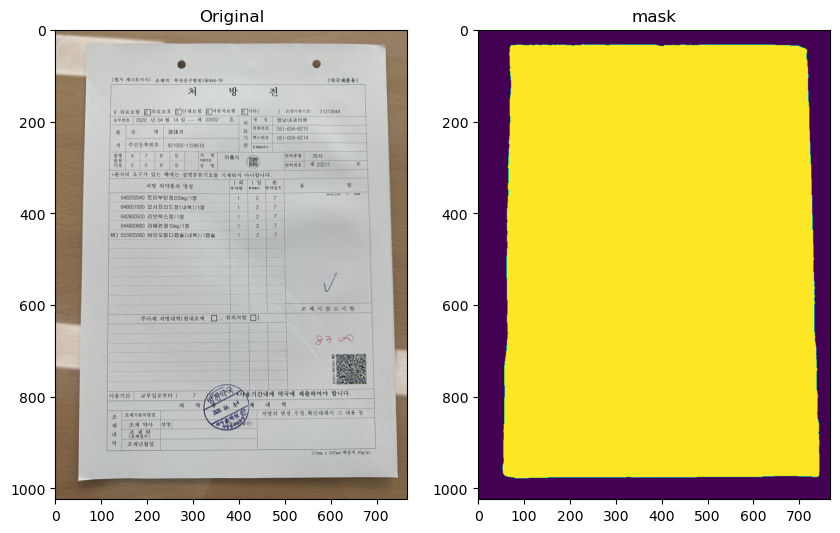

In [17]:
f, axarr = plt.subplots(1,2, figsize=(10,7))

i = -6
#cur_scan = scan_images[i]


axarr[0].imshow(im)
axarr[0].title.set_text('Original')

axarr[1].imshow(mask_det[0])
axarr[1].title.set_text('mask')

# axarr[2].imshow(cur_scan)
# axarr[2].title.set_text('scanned')

In [21]:
mask_to_find = mask_det[0]
mask_to_find = np.array(mask_to_find*255).astype(np.uint8)
contours, hierarchy = cv2.findContours(mask_to_find, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

simplified_contours = []

for cnt in contours:
    hull = cv2.convexHull(cnt)
    simplified_contours.append(cv2.approxPolyDP(hull,
                                                0.001 * cv2.arcLength(hull, True), True))
biggest_n, approx_contour = biggest_contour(simplified_contours, 12192768)

warped = four_point_transform(im, approx_contour)

[[[ 72  35]]

 [[715  45]]

 [[740 974]]

 [[ 55 969]]]
---------
[[ 72.  35.]
 [715.  45.]
 [740. 974.]
 [ 55. 969.]]


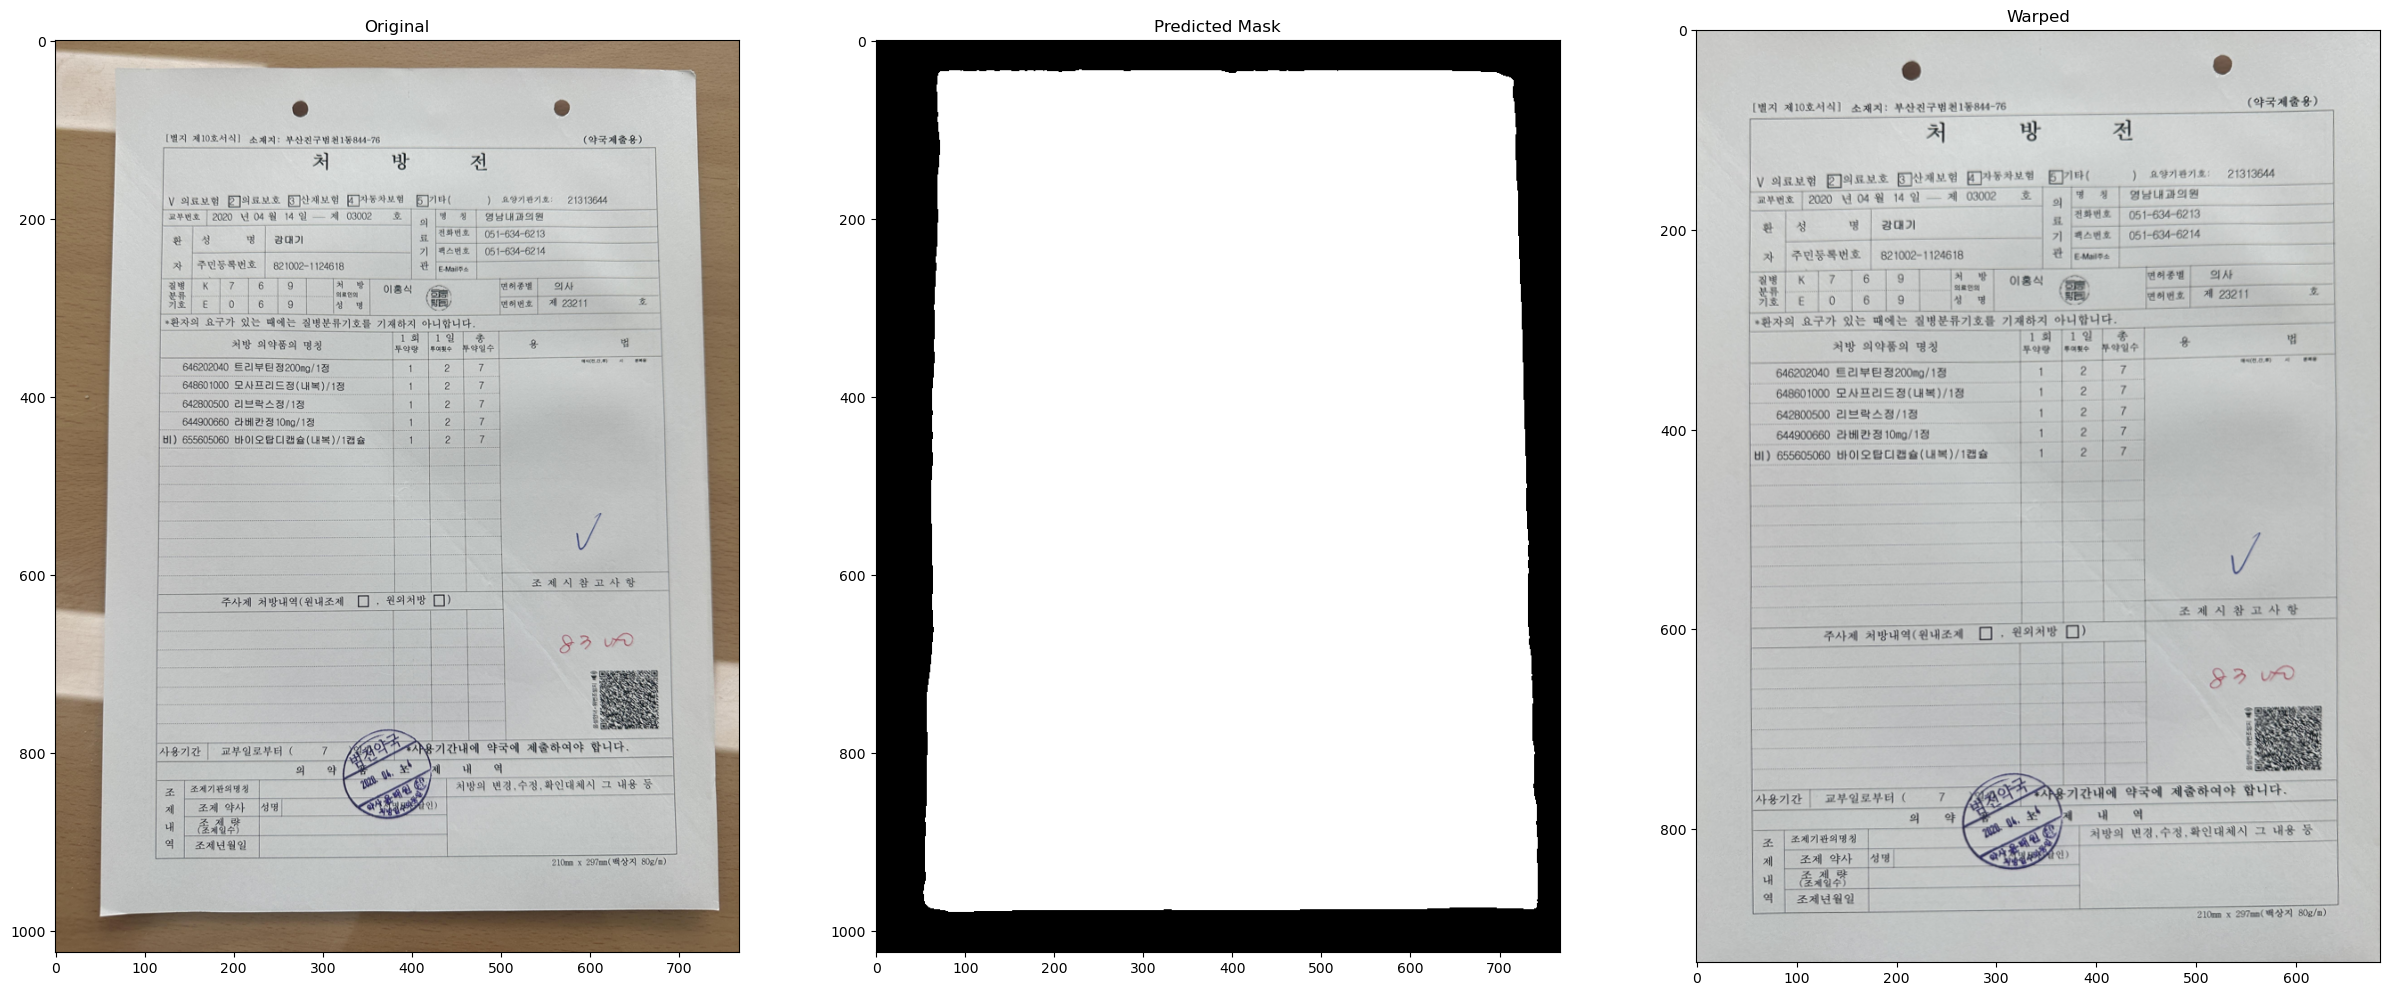

In [22]:
f, axarr = plt.subplots(1,3, figsize=(30,21))

i = -6
#cur_scan = scan_images[i]


axarr[0].imshow(im)
axarr[0].title.set_text('Original')

axarr[1].imshow(mask_det[0], cmap='gray')
axarr[1].title.set_text('Predicted Mask')

axarr[2].imshow(warped)
axarr[2].title.set_text('Warped')

# Make all masks

In [45]:
test_images_base_path = "C:/Users/user/OneDrive - 성균관대학교/Desktop/HealthPort/illumination/final_camera"
crop_images_save_path = "C:/Users/user/OneDrive - 성균관대학교/Desktop/HealthPort/illumination/final_crop"
#orig_folder = "final_camera"


from models.u2net import U2NETP, U2NET
segment = U2NETP(out_ch=1).to(device)

segmentation_model_path = './weights/mask_0326.pth'
segment.load_state_dict(torch.load(segmentation_model_path))

loader = transforms.Compose([transforms.ToTensor()])

In [46]:
num_pixels_x, num_pixels_y, num_channels = 1024, 768, 3

In [48]:
for test_img_path in sorted(os.listdir(test_images_base_path)):

    im = Image.open(f"{test_images_base_path}/{test_img_path}")
    im = ImageOps.exif_transpose(im)
    im = im.resize((num_pixels_y, num_pixels_x))
    im = np.array(im)

    
    image = loader(im).float()
    image = image.unsqueeze(0).to(device)
    

    with torch.no_grad():
        mask = segment(image)

    mask_det = torch.permute(mask[0].detach().cpu(), (0, 2,3, 1)).numpy()
    mask_det = mask_det>0.8

    mask_to_find = mask_det[0]
    mask_to_find = np.array(mask_to_find*255).astype(np.uint8)
    contours, hierarchy = cv2.findContours(mask_to_find, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    simplified_contours = []

    try:
        for cnt in contours:
            hull = cv2.convexHull(cnt)
            simplified_contours.append(cv2.approxPolyDP(hull,
                                                        0.001 * cv2.arcLength(hull, True), True))
        biggest_n, approx_contour = biggest_contour(simplified_contours, 1000)

        warped = four_point_transform(im, approx_contour)

        PIL_image = Image.fromarray(warped.astype('uint8'), 'RGB')
        PIL_image.save(f"{crop_images_save_path}/{test_img_path}")
    except Exception as e:
        print(f"error: {e} -- file: {test_img_path}")

    #break

[[[ 72  35]]

 [[715  45]]

 [[740 974]]

 [[ 55 969]]]
---------
[[ 72.  35.]
 [715.  45.]
 [740. 974.]
 [ 55. 969.]]
[[[737  59]]

 [[658 741]]

 [[ 75 736]]

 [[ 75  60]]]
---------
[[ 75.  60.]
 [737.  59.]
 [658. 741.]
 [ 75. 736.]]
[[[ 765    1]]

 [[ 736 1021]]

 [[   9 1022]]

 [[   5   18]]]
---------
[[5.000e+00 1.800e+01]
 [7.650e+02 1.000e+00]
 [7.360e+02 1.021e+03]
 [9.000e+00 1.022e+03]]
[[[ 764    1]]

 [[ 760 1021]]

 [[   3 1021]]

 [[   1    2]]]
---------
[[1.000e+00 2.000e+00]
 [7.640e+02 1.000e+00]
 [7.600e+02 1.021e+03]
 [3.000e+00 1.021e+03]]
[[[ 62 117]]

 [[663 117]]

 [[659 743]]

 [[ 72 731]]]
---------
[[ 62. 117.]
 [663. 117.]
 [659. 743.]
 [ 72. 731.]]
[[[707  64]]

 [[635 715]]

 [[ 79 718]]

 [[ 74  76]]]
---------
[[ 74.  76.]
 [707.  64.]
 [635. 715.]
 [ 79. 718.]]
[[[  69   36]]

 [[ 696   63]]

 [[ 728 1015]]

 [[   2 1003]]]
---------
[[  69.   36.]
 [ 696.   63.]
 [ 728. 1015.]
 [   2. 1003.]]
[[[  62   59]]

 [[ 723   91]]

 [[ 765 1021]]

 [[  21

[[[671  42]]

 [[728 941]]

 [[  5 974]]

 [[ 82  66]]]
---------
[[ 82.  66.]
 [671.  42.]
 [728. 941.]
 [  5. 974.]]
[[[  12    2]]

 [[ 726   34]]

 [[ 763 1023]]

 [[  41 1002]]]
---------
[[  12.    2.]
 [ 726.   34.]
 [ 763. 1023.]
 [  41. 1002.]]
[[[ 668   40]]

 [[ 737  982]]

 [[  54 1012]]

 [[  39   42]]]
---------
[[  39.   42.]
 [ 668.   40.]
 [ 737.  982.]
 [  54. 1012.]]
[[[ 75  77]]

 [[725  81]]

 [[701 765]]

 [[ 85 751]]]
---------
[[ 75.  77.]
 [725.  81.]
 [701. 765.]
 [ 85. 751.]]
[[[724  44]]

 [[697 726]]

 [[ 72 733]]

 [[ 32  44]]]
---------
[[ 32.  44.]
 [724.  44.]
 [697. 726.]
 [ 72. 733.]]
[[[ 755    1]]

 [[ 693  968]]

 [[   5 1018]]

 [[  30   12]]]
---------
[[3.000e+01 1.200e+01]
 [7.550e+02 1.000e+00]
 [6.930e+02 9.680e+02]
 [5.000e+00 1.018e+03]]
[[[ 709   35]]

 [[ 767 1011]]

 [[  28  991]]

 [[  85   51]]]
---------
[[  85.   51.]
 [ 709.   35.]
 [ 767. 1011.]
 [  28.  991.]]
[[[718   1]]

 [[749 993]]

 [[  7 984]]

 [[ 41   2]]]
---------
[[ 41

[[[ 76  43]]

 [[711  55]]

 [[739 992]]

 [[ 50 981]]]
---------
[[ 76.  43.]
 [711.  55.]
 [739. 992.]
 [ 50. 981.]]
[[[ 73  28]]

 [[712  35]]

 [[742 985]]

 [[ 40 973]]]
---------
[[ 73.  28.]
 [712.  35.]
 [742. 985.]
 [ 40. 973.]]
[[[ 740    8]]

 [[ 767 1023]]

 [[   1 1018]]

 [[  66   24]]]
---------
[[6.600e+01 2.400e+01]
 [7.400e+02 8.000e+00]
 [7.670e+02 1.023e+03]
 [1.000e+00 1.018e+03]]
[[[ 619   26]]

 [[ 672 1016]]

 [[  95 1022]]

 [[ 127   29]]]
---------
[[ 127.   29.]
 [ 619.   26.]
 [ 672. 1016.]
 [  95. 1022.]]
[[[ 700    1]]

 [[ 766 1012]]

 [[   5  985]]

 [[  58   29]]]
---------
[[5.800e+01 2.900e+01]
 [7.000e+02 1.000e+00]
 [7.660e+02 1.012e+03]
 [5.000e+00 9.850e+02]]
[[[ 700    1]]

 [[ 766 1012]]

 [[   5  985]]

 [[  58   29]]]
---------
[[5.800e+01 2.900e+01]
 [7.000e+02 1.000e+00]
 [7.660e+02 1.012e+03]
 [5.000e+00 9.850e+02]]
[[[692  29]]

 [[754 974]]

 [[ 41 955]]

 [[ 81  46]]]
---------
[[ 81.  46.]
 [692.  29.]
 [754. 974.]
 [ 41. 955.]]
[[[ 155

[[[ 758    2]]

 [[ 756 1020]]

 [[   2 1021]]

 [[  58   50]]]
---------
[[  58.   50.]
 [ 758.    2.]
 [ 756. 1020.]
 [   2. 1021.]]
[[[ 82  50]]

 [[690  70]]

 [[682 942]]

 [[ 50 933]]]
---------
[[ 82.  50.]
 [690.  70.]
 [682. 942.]
 [ 50. 933.]]
[[[ 62   1]]

 [[741  30]]

 [[744 976]]

 [[ 99 955]]]
---------
[[ 62.   1.]
 [741.  30.]
 [744. 976.]
 [ 99. 955.]]
[[[698  19]]

 [[767 959]]

 [[ 20 973]]

 [[ 71  34]]]
---------
[[ 71.  34.]
 [698.  19.]
 [767. 959.]
 [ 20. 973.]]
[[[701  55]]

 [[699 738]]

 [[ 86 728]]

 [[ 64  53]]]
---------
[[ 64.  53.]
 [701.  55.]
 [699. 738.]
 [ 86. 728.]]
[[[698  35]]

 [[685 708]]

 [[ 95 721]]

 [[ 33  71]]]
---------
[[ 33.  71.]
 [698.  35.]
 [685. 708.]
 [ 95. 721.]]
[[[ 625    1]]

 [[ 702  990]]

 [[  57 1020]]

 [[ 124    3]]]
---------
[[1.24e+02 3.00e+00]
 [6.25e+02 1.00e+00]
 [7.02e+02 9.90e+02]
 [5.70e+01 1.02e+03]]
[[[ 126   18]]

 [[ 650   25]]

 [[ 654  986]]

 [[ 147 1001]]]
---------
[[ 126.   18.]
 [ 650.   25.]
 [ 654.

[[[ 49  22]]

 [[741  44]]

 [[706 755]]

 [[ 37 745]]]
---------
[[ 49.  22.]
 [741.  44.]
 [706. 755.]
 [ 37. 745.]]
[[[764  13]]

 [[691 745]]

 [[ 56 745]]

 [[ 67  20]]]
---------
[[ 67.  20.]
 [764.  13.]
 [691. 745.]
 [ 56. 745.]]
[[[ 146    1]]

 [[ 697   17]]

 [[ 674  999]]

 [[ 167 1003]]]
---------
[[1.460e+02 1.000e+00]
 [6.970e+02 1.700e+01]
 [6.740e+02 9.990e+02]
 [1.670e+02 1.003e+03]]
[[[ 577   28]]

 [[ 669  981]]

 [[  56 1013]]

 [[ 118   30]]]
---------
[[ 118.   30.]
 [ 577.   28.]
 [ 669.  981.]
 [  56. 1013.]]
[[[ 18  19]]

 [[717  74]]

 [[696 961]]

 [[ 63 991]]]
---------
[[ 18.  19.]
 [717.  74.]
 [696. 961.]
 [ 63. 991.]]
[[[ 83  24]]

 [[677  37]]

 [[716 900]]

 [[ 46 905]]]
---------
[[ 83.  24.]
 [677.  37.]
 [716. 900.]
 [ 46. 905.]]
[[[ 718   24]]

 [[ 767 1019]]

 [[   3  994]]

 [[ 112   75]]]
---------
[[ 112.   75.]
 [ 718.   24.]
 [ 767. 1019.]
 [   3.  994.]]
[[[714   2]]

 [[746 996]]

 [[ 91 952]]

 [[  2   2]]]
---------
[[  2.   2.]
 [714.  

[[[ 702    1]]

 [[ 707 1008]]

 [[   5 1003]]

 [[  14    2]]]
---------
[[1.400e+01 2.000e+00]
 [7.020e+02 1.000e+00]
 [7.070e+02 1.008e+03]
 [5.000e+00 1.003e+03]]
[[[ 748    2]]

 [[ 765 1020]]

 [[   0 1023]]

 [[  43    7]]]
---------
[[  43.    7.]
 [ 748.    2.]
 [ 765. 1020.]
 [   0. 1023.]]
[[[ 718   13]]

 [[ 745 1021]]

 [[   4 1012]]

 [[  46   14]]]
---------
[[  46.   14.]
 [ 718.   13.]
 [ 745. 1021.]
 [   4. 1012.]]
[[[ 66  53]]

 [[728  59]]

 [[702 747]]

 [[ 81 733]]]
---------
[[ 66.  53.]
 [728.  59.]
 [702. 747.]
 [ 81. 733.]]
None
error: 'NoneType' object has no attribute 'reshape' -- file: 조영출_2.jpg
[[[698  48]]

 [[739 959]]

 [[ 67 965]]

 [[ 78  60]]]
---------
[[ 78.  60.]
 [698.  48.]
 [739. 959.]
 [ 67. 965.]]
[[[ 61   1]]

 [[695  45]]

 [[749 952]]

 [[116 932]]]
---------
[[ 61.   1.]
 [695.  45.]
 [749. 952.]
 [116. 932.]]
[[[ 606   44]]

 [[ 687  975]]

 [[  88 1002]]

 [[ 132   42]]]
---------
[[ 132.   42.]
 [ 606.   44.]
 [ 687.  975.]
 [  88. 100

In [ ]:

def biggest_contour(contours, min_area):
    biggest = None
    max_area = 0
    biggest_n = 0
    approx_contour = None
    for n, i in enumerate(contours):
        area = cv2.contourArea(i)

        if area > min_area / 30:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
                biggest_n = n
                approx_contour = approx

    return biggest_n, approx_contour


def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    pts = pts.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect


# ## Find the exact (x,y) coordinates of the biggest contour and crop it out


def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    print(pts)
    rect = order_points(pts)
    print("---------")
    print(rect)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

# Make numpy arrays

In [53]:
crop_images_save_path = "C:/Users/user/OneDrive - 성균관대학교/Desktop/HealthPort/illumination/final_crop"
scan_images_base_path = "C:/Users/user/OneDrive - 성균관대학교/Desktop/HealthPort/illumination/final_scan"

In [61]:
num_pixels_x, num_pixels_y, num_channels = 1024//1, 768//1, 3

crop_images = np.zeros((len(os.listdir(crop_images_save_path)), num_pixels_x, num_pixels_y, num_channels), dtype=np.uint8)
scan_images = np.zeros((len(os.listdir(crop_images_save_path)), num_pixels_x, num_pixels_y, num_channels), dtype=np.uint8)

In [63]:
from tqdm import tqdm
for count, im_path in enumerate(tqdm(sorted(os.listdir(crop_images_save_path)))):

    im_crop = Image.open(f"{crop_images_save_path}/{im_path}").convert('RGB')
    im_scan = Image.open(f"{scan_images_base_path}/{im_path}").convert('RGB')
    
    im_crop = ImageOps.exif_transpose(im_crop)
    im_scan = ImageOps.exif_transpose(im_scan)
    
    im_crop = im_crop.resize((num_pixels_y, num_pixels_x))
    im_scan = im_scan.resize((num_pixels_y, num_pixels_x))
    
    im_crop = np.array(im_crop)
    im_scan = np.array(im_scan)

    crop_images[count] = im_crop
    scan_images[count] = im_scan
    #print(i)

100%|████████████████████████████████████████████████████████████████████████████████| 363/363 [00:41<00:00,  8.71it/s]


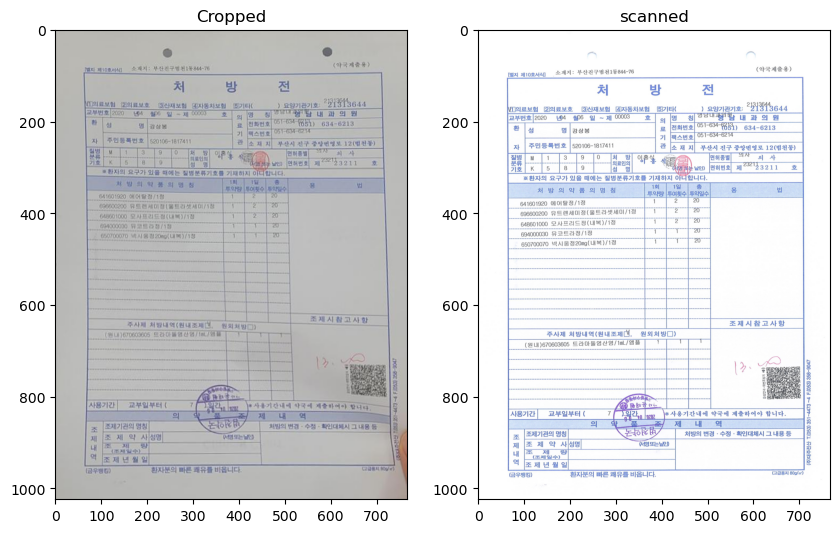

In [68]:
f, axarr = plt.subplots(1,2, figsize=(10,7))

i = 1


cur_orig = crop_images[i]
cur_mask = scan_images[i]


axarr[0].imshow(cur_orig)
axarr[0].title.set_text('Cropped')

axarr[1].imshow(cur_mask, cmap='gray')
axarr[1].title.set_text('scanned')

In [ ]:
base_path = "/srv/data/hamin/OCR/healthport/segmentation"

pixel_size = 1024

    
# with open(f"{base_path}/orig_{pixel_size}.npy", 'wb') as f:
#     np.save(f, orig_images)
    
# with open(f"{base_path}/mask_{pixel_size}.npy", 'wb') as f:
#     np.save(f, mask_images)
    
    

    
# with open(f"{base_path}/orig_{pixel_size}.npy", 'rb') as f:
#     orig_images = np.load(f)
    
# with open(f"{base_path}/mask_{pixel_size}.npy", 'rb') as f:
#     mask_images = np.load(f)    